Use Volume Traded Times Change In Price Over Interval As Signal

Large volume --> momentum.
Small volume --> reversal.

In [2]:
strat_univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

## Load And Structure Data

In [3]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
data_freq = '4h'
look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'

In [5]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for ADAUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XRPUSDT.
Downloaded data for DOTUSDT.
Downloaded data for MATICUSDT.


In [6]:
px_data

{'BTCUSDT':                                open            high             low  \
 open_time                                                             
 2020-01-01 00:00:00   7180.46000000   7238.03000000   7175.62000000   
 2020-01-01 04:00:00   7226.19000000   7231.70000000   7196.20000000   
 2020-01-01 08:00:00   7209.50000000   7231.17000000   7181.17000000   
 2020-01-01 12:00:00   7193.32000000   7244.43000000   7193.32000000   
 2020-01-01 16:00:00   7237.54000000   7245.54000000   7215.51000000   
 ...                             ...             ...             ...   
 2025-03-05 20:00:00  89900.00000000  90751.45000000  89707.34000000   
 2025-03-06 00:00:00  90302.56000000  91914.21000000  89988.21000000   
 2025-03-06 04:00:00  91388.38000000  92679.48000000  91334.38000000   
 2025-03-06 08:00:00  91565.35000000  91608.39000000  90659.04000000   
 2025-03-06 12:00:00  91272.40000000  91280.38000000  90702.20000000   
 
                               close       volume  

In [7]:
for ticker in px_data:
    print(ticker)

BTCUSDT
ETHUSDT
ADAUSDT
BNBUSDT
XRPUSDT
DOTUSDT
MATICUSDT


In [13]:
btc_price_volume_df = px_data['BTCUSDT'][[
    "close", "volume", "quote_volume", "num_trades", "taker_base_volume", "taker_quote_volume"
]]
btc_price_volume_df = btc_price_volume_df.astype(float)
btc_price_volume_df

,close,volume,quote_volume,num_trades,taker_base_volume,taker_quote_volume
open_time,,,,,,
2020-01-01 00:00:00,7230.71,12.760445,92038.714925,136.0,6.774599,48856.545325
2020-01-01 04:00:00,7205.50,1.111320,8019.121424,64.0,0.518253,3740.423316
2020-01-01 08:00:00,7195.80,2.097358,15104.198332,61.0,1.105310,7957.894896
2020-01-01 12:00:00,7233.02,7.531506,54379.119990,111.0,4.235354,30569.135691
2020-01-01 16:00:00,7223.72,5.494401,39733.518352,80.0,2.658221,19232.354030
...,...,...,...,...,...,...
2025-03-05 20:00:00,90301.74,4.132170,372107.527537,822.0,3.727850,335656.401015
2025-03-06 00:00:00,91613.39,2.662260,242800.243043,693.0,1.618830,148108.510382
2025-03-06 04:00:00,91572.68,2.554470,234618.840804,454.0,1.649640,151645.081785


<Axes: xlabel='open_time'>

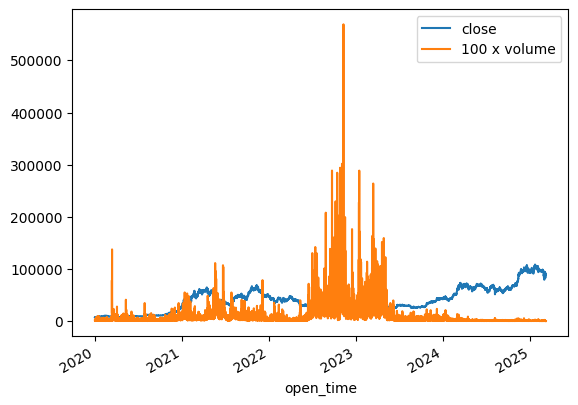

In [16]:
btc_price_volume_df["100 x volume"] = 100 * btc_price_volume_df["volume"]
btc_price_volume_df[["close", "100 x volume"]].plot()

In [17]:
btc_price_volume_df[["close", "volume"]].corr()

,close,volume
close,1.000000,-0.226004
volume,-0.226004,1.000000


In [35]:
import numpy as np

btc_price_volume_df[["volume", "quote_volume", "num_trades"]].corrwith(btc_price_volume_df["close"].shift(2))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


volume         -0.225182
quote_volume   -0.134485
num_trades     -0.132522
dtype: float64

In [52]:
btc_signals = pd.DataFrame(0.0, columns = [], index=btc_price_volume_df.index)

btc_signals["price past 1"] = btc_price_volume_df["close"].shift()
btc_signals["log price past 1"] = np.log(btc_price_volume_df["close"].shift())
btc_signals["price past 2"] = btc_price_volume_df["close"].shift(2)
btc_signals["log price past 2"] = np.log(btc_price_volume_df["close"].shift(2))
btc_signals["prev price diff"] = (btc_price_volume_df["close"].shift() - btc_price_volume_df["close"].shift(2))
btc_signals["log prev price diff"] = np.log(btc_signals["prev price diff"])
btc_signals["prev return"] = btc_signals["prev price diff"] / btc_signals["price past 2"]
btc_signals["log prev quotient"] = np.log(btc_signals["price past 1"]) - np.log(btc_signals["price past 2"])

btc_signals["volume past 2"] = btc_price_volume_df["volume"].shift(2)
btc_signals["volume past 1"] = btc_price_volume_df["volume"].shift()

btc_signals["price change x volume"] = btc_signals["prev price diff"] * btc_signals["volume past 1"]
btc_signals["return x volume"] = btc_signals["prev return"] * btc_signals["volume past 1"]

btc_signals

/Users/wchristerson/anaconda3/envs/myenv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/wchristerson/anaconda3/envs/myenv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,price past 1,log price past 1,price past 2,log price past 2,prev price diff,log prev price diff,prev return,log prev quotient,volume past 2,volume past 1,price change x volume,return x volume
open_time,,,,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,7230.71,8.886093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.760445,NaN,NaN
2020-01-01 08:00:00,7205.50,8.882600,7230.71,8.886093,-25.21,NaN,-0.003487,-0.003493,12.760445,1.111320,-28.016377,-0.003875
2020-01-01 12:00:00,7195.80,8.881253,7205.50,8.882600,-9.70,NaN,-0.001346,-0.001347,1.111320,2.097358,-20.344373,-0.002823
2020-01-01 16:00:00,7233.02,8.886412,7195.80,8.881253,37.22,3.616846,0.005172,0.005159,2.097358,7.531506,280.322653,0.038956
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-05 20:00:00,89899.96,11.406453,88522.80,11.391015,1377.16,7.227779,0.015557,0.015437,2.594580,2.411050,3320.401618,0.037509
2025-03-06 00:00:00,90301.74,11.410912,89899.96,11.406453,401.78,5.995905,0.004469,0.004459,2.411050,4.132170,1660.223263,0.018467
2025-03-06 04:00:00,91613.39,11.425333,90301.74,11.410912,1311.65,7.179041,0.014525,0.014421,4.132170,2.662260,3491.953329,0.038670


In [53]:
btc_signals.corrwith(btc_price_volume_df["close"])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/wchristerson/anaconda3/envs/myenv/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


price past 1             0.999695
log price past 1         0.934065
price past 2             0.999417
log price past 2         0.933874
prev price diff          0.017192
log prev price diff           NaN
prev return              0.005645
log prev quotient        0.006105
volume past 2           -0.225914
volume past 1           -0.225899
price change x volume    0.001868
return x volume          0.002386
dtype: float64